In [8]:
# enable autoreload
%load_ext autoreload
%autoreload 2

import sys, os
from monai.losses import DiceCELoss
from pathlib import Path
import torch

# insert the project root (one level up from this folder) onto sys.path
ROOT = Path(os.getcwd()).parent.resolve()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))
    
from src.inference.inference import run_inference, evaluate, ensemble_inference
from src.utils.visualization import visualize_slices

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
exp = "exp25_nnunet"
fold = "fold4"
preds = ROOT / "results" / exp / fold / "predictions"

DATA_DIR       = "/datasets/tdt4265/mic/open/HNTS-MRG"
CHECKPOINT     = ROOT / "results" / exp / fold / "checkpoints/best.ckpt"
OUTPUT_DIR     = ROOT / "results" / exp /"inference" / "single_model"
BATCH_SIZE     = 3
MODEL_TYPE     = "nnunet"
DEVICE         = torch.device("cuda:0")  

In [13]:
loss_fn = DiceCELoss(
    to_onehot_y=True, softmax=True,
    lambda_dice=0.5, lambda_ce=0.5
)

In [14]:
# Single model
model, loader = run_inference(DATA_DIR, CHECKPOINT, OUTPUT_DIR, BATCH_SIZE, MODEL_TYPE, DEVICE)
metrics = evaluate(model, loader, loss_fn, DEVICE)
# print the metrics
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")

Inference: 100%|██████████| 7/7 [00:01<00:00,  4.72it/s]


Inference done; outputs in /home/herminea/tdt4265_mini_project/results/exp25_nnunet/inference/single_model


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 12.28it/s]

avg_loss: 0.1742
mean_dice: 0.7006
dice_class1: 0.8736
dice_class2: 0.5276
prec_class1: 0.6388
recall_class1: 0.6996
prec_class2: 0.7126
recall_class2: 0.7157


In [15]:
# Ensemble
CKPT_GLOB = str(ROOT / "results" / exp / "fold[0-3]" / "checkpoints" / "best.ckpt")
OUT_ENS   = ROOT / "results" / exp / "inference" / "ensemble"

# run inference and grab model + loader
models, loader = ensemble_inference(DATA_DIR, OUT_ENS, CKPT_GLOB, MODEL_TYPE, BATCH_SIZE, DEVICE)
metrics_ens = evaluate(models, loader, loss_fn, DEVICE)
# print the metrics
for key, value in metrics_ens.items():
    print(f"{key}: {value:.4f}")

Ensemble Inference: 100%|██████████| 7/7 [00:11<00:00,  1.59s/it]


Ensembled predictions saved to /home/herminea/tdt4265_mini_project/results/exp25_nnunet/inference/ensemble


Evaluation: 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]

avg_loss: 0.1892
mean_dice: 0.7146
dice_class1: 0.8816
dice_class2: 0.5477
prec_class1: 0.6863
recall_class1: 0.6523
prec_class2: 0.7125
recall_class2: 0.5560


Label class distribution: (1738493, 22930, 8049)
Prediction class distribution: (1750965, 9749, 8758)


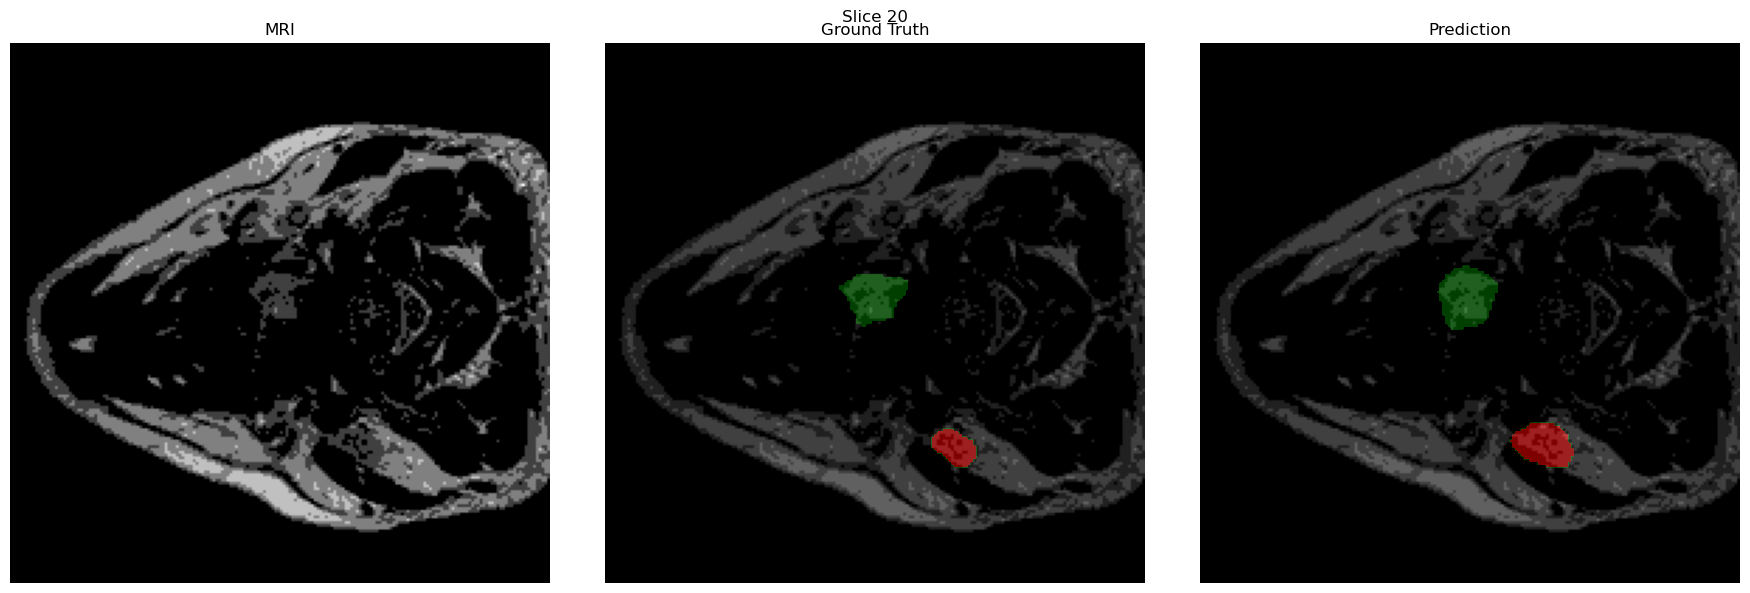

In [7]:
# Visualize
visualize_slices(f"{OUT_ENS}/image_3.nii.gz",
                 f"{OUT_ENS}/label_3.nii.gz",
                 f"{OUT_ENS}/prediction_3.nii.gz", slice_idx=20)
